# Cross-Asset Volatility Forecasting: Multi-Horizon Analysis with Trading Strategies

This notebook extends the volatility forecasting framework to:
- **30 stocks** across market caps and sectors (SPY, QQQ + 28 others)
- **Multiple forecast horizons**: 1d, 5d, 20d
- **GARCH/EGARCH baselines**: Additional econometric benchmarks
- **Trading strategies**: Vol-scaled strategies with transaction costs
- **Performance metrics**: Sharpe ratios, drawdowns, robustness across periods
- **Honest analysis**: What works and what doesn't

Uses the same feature engineering, models, and evaluation framework as `main.ipynb`.

## Debug Mode

Set `DEBUG_MODE = True` in Cell 1 to run a quick test with:
- **1 stock** (SPY)
- **2 horizons** (1d, 5d)

This allows you to verify that all models (GARCH, EGARCH, etc.) and visualizations work correctly before running the full analysis.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from scipy import fft, signal
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize_scalar
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# ============================================================================
# CONFIGURATION
# ============================================================================

# DEBUG MODE: Set to True for quick testing (1 stock, 2 horizons)
DEBUG_MODE = False  # Set to False for full analysis

# Core parameters
ROLLING_WINDOW = 30
FORECAST_HORIZONS = [1, 5] if DEBUG_MODE else [1, 5, 20]  # Multiple horizons: 1d, 5d, 20d

# Feature toggles
ENABLE_SARIMA = True
ENABLE_FOURIER = True
SARIMA_REFIT_FREQ = 5

# Data quality filters
MIN_BARS_PER_DAY = 20
FILTER_WEEKENDS = True
FILTER_ZERO_RV = True

# Neural network parameters
NN_EPOCHS = 500
NN_PATIENCE = 50
NN_BATCH_SIZE = 64

# Technical indicator parameters
RSI_PERIOD = 14
AUTOCORR_LAGS = [1, 2, 3, 5, 10]

# Feature parameters
RV_RATIO_LOOKBACK_20D = 20
RV_RATIO_2D_14D = (2, 14)

# Time series parameters
FOURIER_WINDOW = 63
SARIMA_WINDOW = 252
SARIMA_ORDER = (1, 1, 1)
SARIMA_SEASONAL = (1, 1, 1, 5)

# Trading strategy parameters
TRANSACTION_COST_BPS = 5  # 5 basis points per trade
INITIAL_CAPITAL = 100000  # $100k initial capital
MIN_POSITION_SIZE = 0.1  # Minimum position size (10%) - filter out weak signals that won't cover transaction costs

# Selected stocks (30 total: SPY, QQQ + 28 others across sectors)
SELECTED_STOCKS_FULL = [
    # ETFs
    'SPY', 'QQQ',
    # Tech
    'AAPL', 'MSFT', 'NVDA', 'GOOGL', 'META', 'AMD', 'INTC',
    # Finance
    'JPM', 'BAC', 'GS', 'MS', 'C',
    # Healthcare
    'JNJ', 'PFE', 'UNH', 'LLY', 'ABBV',
    # Consumer
    'AMZN', 'HD', 'MCD', 'NKE', 'SBUX',
    # Energy
    'XOM', 'CVX', 'COP',
    # Industrial
    'BA', 'CAT', 'GE',
    # Other
    'TSLA', 'WMT', 'V'
]

# Use debug mode selection
SELECTED_STOCKS = ['SPY'] if DEBUG_MODE else SELECTED_STOCKS_FULL

print(f"Configuration:")
print(f"  DEBUG_MODE: {DEBUG_MODE}")
if DEBUG_MODE:
    print(f"  ⚠️  DEBUG MODE: Testing with 1 stock and 2 horizons")
print(f"  Rolling window: {ROLLING_WINDOW} days")
print(f"  Forecast horizons: {FORECAST_HORIZONS} days")
print(f"  Number of assets: {len(SELECTED_STOCKS)}")
print(f"  Transaction cost: {TRANSACTION_COST_BPS} bps")
print(f"  Feature toggles: SARIMA={ENABLE_SARIMA}, Fourier={ENABLE_FOURIER}")
print()


Configuration:
  DEBUG_MODE: False
  Rolling window: 30 days
  Forecast horizons: [1, 5, 20] days
  Number of assets: 33
  Transaction cost: 5 bps
  Feature toggles: SARIMA=True, Fourier=True



In [2]:
# ============================================================================
# HELPER FUNCTIONS (from main.ipynb)
# ============================================================================

def compute_rsi(series, period=14):
    """Compute Relative Strength Index (RSI) on a series."""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_rolling_autocorr(series, window, lag):
    """Compute rolling autocorrelation at a specific lag."""
    result = pd.Series(index=series.index, dtype=float)
    for i in range(window + lag - 1, len(series)):
        window_data = series.iloc[i - window + 1:i + 1]
        if len(window_data) >= window:
            x = window_data.iloc[lag:].values
            y = window_data.iloc[:-lag].values
            if len(x) > 1 and np.std(x) > 0 and np.std(y) > 0:
                corr = np.corrcoef(x, y)[0, 1]
                result.iloc[i] = corr
            else:
                result.iloc[i] = np.nan
        else:
            result.iloc[i] = np.nan
    return result

def compute_metrics(y_true, y_pred, y_true_rv_diff=None, y_pred_rv_diff=None):
    """Compute comprehensive metrics for RV change forecasting."""
    metrics = {}
    metrics['rmse_logdiff'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['mae_logdiff'] = mean_absolute_error(y_true, y_pred)
    
    if y_true_rv_diff is not None and y_pred_rv_diff is not None:
        metrics['rmse_diff'] = np.sqrt(mean_squared_error(y_true_rv_diff, y_pred_rv_diff))
        metrics['mae_diff'] = mean_absolute_error(y_true_rv_diff, y_pred_rv_diff)
        
        # Directional accuracy
        mask = (y_true_rv_diff != 0) & (y_pred_rv_diff != 0)
        if mask.sum() > 0:
            true_sign = np.sign(y_true_rv_diff[mask])
            pred_sign = np.sign(y_pred_rv_diff[mask])
            metrics['directional_accuracy'] = np.mean(true_sign == pred_sign)
        else:
            metrics['directional_accuracy'] = np.nan
    
    if len(y_true) > 1:
        corr, pval = pearsonr(y_true, y_pred)
        metrics['correlation'] = corr
        metrics['correlation_pval'] = pval
    else:
        metrics['correlation'] = np.nan
        metrics['correlation_pval'] = np.nan
    
    return metrics

print("Helper functions loaded.")


Helper functions loaded.


In [3]:
# ============================================================================
# DATA LOADING AND PROCESSING
# ============================================================================

def load_and_process_stock(ticker, data_dir='10y data'):
    """Load and process a single stock's 15-min data into daily RV."""
    csv_path = Path(f'{data_dir}/{ticker}_15m_prices.csv')
    
    if not csv_path.exists():
        print(f"Warning: {csv_path} not found, skipping {ticker}")
        return None
    
    df = pd.read_csv(csv_path)
    
    # Find date column
    date_cols = [c for c in df.columns if c.lower() in ['date','datetime','timestamp']]
    if not date_cols:
        print(f"Warning: No date column found for {ticker}")
        return None
    
    # Parse datetime
    df.index = pd.to_datetime(df[date_cols[0]], utc=True, errors='coerce')
    df = df.drop(columns=[date_cols[0]]).sort_index()
    df.index = df.index.tz_convert('America/New_York')
    
    # Find close column
    close_col = None
    for col in df.columns:
        if 'close' in col.lower():
            close_col = col
            break
    
    if close_col is None:
        print(f"Warning: No close column found for {ticker}")
        return None
    
    df['close'] = df[close_col].astype(float)
    
    # Compute log returns
    ret_15m = np.log(df['close']).diff().dropna()
    
    # Count bars per day
    bars_per_day = ret_15m.groupby(pd.Grouper(freq='D')).count()
    
    # Daily realized variance and volatility
    daily_rv_squared = ret_15m.groupby(pd.Grouper(freq='D')).apply(lambda x: (x ** 2).sum())
    daily_rv = np.sqrt(daily_rv_squared) * np.sqrt(252)  # Annualized
    
    # Data quality filtering
    daily_rv = daily_rv.dropna()
    
    if MIN_BARS_PER_DAY > 0:
        valid_days = bars_per_day[bars_per_day >= MIN_BARS_PER_DAY].index
        daily_rv = daily_rv[daily_rv.index.isin(valid_days)]
    
    if FILTER_WEEKENDS:
        daily_rv = daily_rv[daily_rv.index.dayofweek < 5]
    
    if FILTER_ZERO_RV:
        daily_rv = daily_rv[daily_rv > 0]
    
    return daily_rv, ret_15m

# Load all stocks
print("Loading and processing stocks...")
stock_data = {}
ret_data = {}

for ticker in tqdm(SELECTED_STOCKS, desc="Loading stocks"):
    result = load_and_process_stock(ticker)
    if result is not None:
        daily_rv, ret_15m = result
        stock_data[ticker] = daily_rv
        ret_data[ticker] = ret_15m
        print(f"  {ticker}: {len(daily_rv)} days, range {daily_rv.index.min()} to {daily_rv.index.max()}")
    else:
        print(f"  {ticker}: FAILED to load")

print(f"\nSuccessfully loaded {len(stock_data)} stocks")


Loading and processing stocks...


Loading stocks:   3%|▎         | 1/33 [00:00<00:11,  2.72it/s]

  SPY: 2512 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:   6%|▌         | 2/33 [00:00<00:09,  3.32it/s]

  QQQ: 2512 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:   9%|▉         | 3/33 [00:00<00:08,  3.56it/s]

  AAPL: 2512 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  12%|█▏        | 4/33 [00:01<00:07,  3.76it/s]

  MSFT: 2512 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  15%|█▌        | 5/33 [00:01<00:07,  3.87it/s]

  NVDA: 2510 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  21%|██        | 7/33 [00:01<00:05,  5.00it/s]

  GOOGL: 2501 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00
  META: 1012 days, range 2021-06-30 00:00:00-04:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  24%|██▍       | 8/33 [00:01<00:05,  4.64it/s]

  AMD: 2512 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  27%|██▋       | 9/33 [00:02<00:05,  4.50it/s]

  INTC: 2510 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  30%|███       | 10/33 [00:02<00:05,  4.53it/s]

  JPM: 2508 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  33%|███▎      | 11/33 [00:02<00:04,  4.41it/s]

  BAC: 2512 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  36%|███▋      | 12/33 [00:02<00:04,  4.56it/s]

  GS: 2502 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00
  MS: 2501 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  42%|████▏     | 14/33 [00:03<00:04,  4.63it/s]

  C: 2510 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  45%|████▌     | 15/33 [00:03<00:04,  4.44it/s]

  JNJ: 2503 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  52%|█████▏    | 17/33 [00:03<00:03,  4.63it/s]

  PFE: 2508 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00
  UNH: 2494 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  58%|█████▊    | 19/33 [00:04<00:02,  4.91it/s]

  LLY: 2497 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00
  ABBV: 2496 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  64%|██████▎   | 21/33 [00:04<00:02,  4.77it/s]

  AMZN: 2512 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00
  HD: 2501 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  67%|██████▋   | 22/33 [00:04<00:02,  4.88it/s]

  MCD: 2502 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  70%|██████▉   | 23/33 [00:05<00:02,  4.82it/s]

  NKE: 2511 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  73%|███████▎  | 24/33 [00:05<00:01,  4.80it/s]

  SBUX: 2506 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  76%|███████▌  | 25/33 [00:05<00:01,  4.69it/s]

  XOM: 2511 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  82%|████████▏ | 27/33 [00:05<00:01,  4.80it/s]

  CVX: 2507 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00
  COP: 2502 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  88%|████████▊ | 29/33 [00:06<00:00,  4.79it/s]

  BA: 2506 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00
  CAT: 2505 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  91%|█████████ | 30/33 [00:06<00:00,  4.68it/s]

  GE: 2509 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  94%|█████████▍| 31/33 [00:06<00:00,  4.47it/s]

  TSLA: 2511 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks:  97%|█████████▋| 32/33 [00:07<00:00,  4.54it/s]

  WMT: 2510 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00
  V: 2507 days, range 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00


Loading stocks: 100%|██████████| 33/33 [00:07<00:00,  4.51it/s]


Successfully loaded 33 stocks


In [4]:
# ============================================================================
# FEATURE ENGINEERING (from main.ipynb framework)
# ============================================================================

def create_features(daily_rv, forecast_target):
    """Create all features for a given stock and forecast horizon."""
    # Target: subsequent forecast_target-day rolling window mean vol
    rv_fwd_values = []
    rv_fwd_index = []
    
    for i in range(len(daily_rv)):
        if i + forecast_target < len(daily_rv):
            future_mean = daily_rv.iloc[i+1:i+1+forecast_target].mean()
            rv_fwd_values.append(future_mean)
            rv_fwd_index.append(daily_rv.index[i])
    
    rv_fwd = pd.Series(rv_fwd_values, index=rv_fwd_index)
    
    # Compute RV change targets
    eps = 1e-12
    rv_diff = rv_fwd - daily_rv.loc[rv_fwd.index]
    rv_logdiff = np.log(rv_fwd + eps) - np.log(daily_rv.loc[rv_fwd.index] + eps)
    
    # Technical indicators
    rsi_vol = compute_rsi(daily_rv, period=RSI_PERIOD)
    
    # Autocorrelation features
    autocorr_features = {}
    for lag in AUTOCORR_LAGS:
        window_size = max(ROLLING_WINDOW, 2 * lag + 5)
        autocorr_features[f'autocorr_lag{lag}'] = compute_rolling_autocorr(daily_rv, window=window_size, lag=lag)
    
    # RV ratios
    rv_ratio_20d = daily_rv / daily_rv.shift(RV_RATIO_LOOKBACK_20D)
    rv_ratio_2d_14d = daily_rv.shift(RV_RATIO_2D_14D[0]) / daily_rv.shift(RV_RATIO_2D_14D[1])
    
    # Rolling correlation
    corr_window = max(ROLLING_WINDOW, 20)
    rv_ratio_2d_14d_series = daily_rv.shift(RV_RATIO_2D_14D[0]) / daily_rv.shift(RV_RATIO_2D_14D[1])
    rv_corr_ratio = pd.Series(index=daily_rv.index, dtype=float)
    for i in range(corr_window, len(daily_rv)):
        window_ratio = rv_ratio_2d_14d_series.iloc[i-corr_window+1:i+1]
        window_rv = daily_rv.iloc[i-corr_window+1:i+1]
        mask = ~(window_ratio.isna() | window_rv.isna())
        if mask.sum() > 5:
            corr_val = np.corrcoef(window_ratio[mask].values, window_rv[mask].values)[0, 1]
            rv_corr_ratio.iloc[i] = corr_val if not np.isnan(corr_val) else np.nan
    
    # Time features
    day_of_week = daily_rv.index.dayofweek
    week_of_month = (daily_rv.index.day - 1) // 7 + 1
    month_of_year = daily_rv.index.month
    
    # Additional correlations and ranks
    rv_vol_corr_ratio = pd.Series(index=daily_rv.index, dtype=float)
    for i in range(corr_window, len(daily_rv)):
        window_vol = daily_rv.iloc[i-corr_window+1:i+1]
        window_corr = rv_corr_ratio.iloc[i-corr_window+1:i+1]
        mask = ~(window_vol.isna() | window_corr.isna())
        if mask.sum() > 5:
            corr_val = np.corrcoef(window_vol[mask].values, window_corr[mask].values)[0, 1]
            rv_vol_corr_ratio.iloc[i] = corr_val if not np.isnan(corr_val) else np.nan
    
    rsi_vol_rank = rsi_vol.expanding(min_periods=50).rank(pct=True)
    rv_ratio_20d_rank = rv_ratio_20d.expanding(min_periods=50).rank(pct=True)
    
    rolling_rv_21d = daily_rv.rolling(window=21, min_periods=21).mean()
    is_rv_gt_21d_mean = (daily_rv > rolling_rv_21d).astype(int)
    rv_today_ratio_21d_mean = daily_rv / rolling_rv_21d
    rv_today_ratio_21d_mean_rank = rv_today_ratio_21d_mean.expanding(min_periods=50).rank(pct=True)
    
    # Lagged RV features
    rv_lag1 = daily_rv.shift(1)
    rv_lag2 = daily_rv.shift(2)
    rv_lag5 = daily_rv.shift(5)
    rv_lag10 = daily_rv.shift(10)
    rv_change_1 = daily_rv - daily_rv.shift(1)
    rv_change_5 = daily_rv - daily_rv.shift(5)
    past_mean_7 = daily_rv.shift(1).rolling(window=7, min_periods=1).mean()
    past_mean_diff_7 = past_mean_7 - daily_rv
    
    # Fourier features (simplified - can be slow)
    fourier_dominant_freq = pd.Series(index=daily_rv.index, dtype=float)
    fourier_dominant_amp = pd.Series(index=daily_rv.index, dtype=float)
    fourier_total_energy = pd.Series(index=daily_rv.index, dtype=float)
    
    if ENABLE_FOURIER:
        for i in range(FOURIER_WINDOW - 1, len(daily_rv)):
            window_data = daily_rv.iloc[max(0, i - FOURIER_WINDOW + 1):i + 1].values
            if len(window_data) >= 20:
                try:
                    fft_vals = fft.fft(window_data)
                    freqs = fft.fftfreq(len(window_data))
                    power = np.abs(fft_vals)**2
                    power[0] = 0
                    dominant_idx = np.argmax(power[1:len(power)//2]) + 1
                    fourier_dominant_freq.iloc[i] = abs(freqs[dominant_idx])
                    fourier_dominant_amp.iloc[i] = power[dominant_idx]
                    fourier_total_energy.iloc[i] = np.sum(power)
                except:
                    pass
    
    # SARIMA features (simplified)
    sarima_forecast = pd.Series(index=daily_rv.index, dtype=float)
    sarima_residual_std = pd.Series(index=daily_rv.index, dtype=float)
    
    if ENABLE_SARIMA:
        last_fitted_model = None
        last_fitted_idx = -1
        for i in range(SARIMA_WINDOW - 1, len(daily_rv)):
            window_data = daily_rv.iloc[max(0, i - SARIMA_WINDOW + 1):i + 1].values
            if len(window_data) >= SARIMA_WINDOW // 2:
                if (i - last_fitted_idx) >= SARIMA_REFIT_FREQ or last_fitted_model is None:
                    try:
                        model = SARIMAX(window_data, order=SARIMA_ORDER, seasonal_order=SARIMA_SEASONAL,
                                       enforce_stationarity=False, enforce_invertibility=False)
                        fitted_model = model.fit(disp=False, maxiter=50)
                        last_fitted_model = fitted_model
                        last_fitted_idx = i
                    except:
                        pass
            
            if last_fitted_model is not None:
                try:
                    forecast = last_fitted_model.forecast(steps=1)
                    sarima_forecast.iloc[i] = forecast[0] if len(forecast) > 0 else np.nan
                    residuals = last_fitted_model.resid
                    sarima_residual_std.iloc[i] = np.std(residuals) if len(residuals) > 0 else np.nan
                except:
                    pass
    
    # Create feature dataframe
    df_features = pd.DataFrame({
        'rv_today': daily_rv,
        f'rv_fwd_{forecast_target}d': rv_fwd,
        f'rv_diff_{forecast_target}d': rv_diff,
        f'rv_logdiff_{forecast_target}d': rv_logdiff,
        'rsi_vol': rsi_vol,
        'rv_ratio_20d': rv_ratio_20d,
        'rv_ratio_2d_14d': rv_ratio_2d_14d,
        'rv_corr_ratio': rv_corr_ratio,
        'day_of_week': day_of_week,
        'week_of_month': week_of_month,
        'month_of_year': month_of_year,
        'rv_vol_corr_ratio': rv_vol_corr_ratio,
        'rsi_vol_rank': rsi_vol_rank,
        'rv_ratio_20d_rank': rv_ratio_20d_rank,
        'is_rv_gt_21d_mean': is_rv_gt_21d_mean,
        'rv_today_ratio_21d_mean': rv_today_ratio_21d_mean,
        'rv_today_ratio_21d_mean_rank': rv_today_ratio_21d_mean_rank,
        'rv_lag1': rv_lag1,
        'rv_lag2': rv_lag2,
        'rv_lag5': rv_lag5,
        'rv_lag10': rv_lag10,
        'rv_change_1': rv_change_1,
        'rv_change_5': rv_change_5,
        'past_mean_7': past_mean_7,
        'past_mean_diff_7': past_mean_diff_7,
        'fourier_dominant_freq': fourier_dominant_freq,
        'fourier_dominant_amp': fourier_dominant_amp,
        'fourier_total_energy': fourier_total_energy,
        'sarima_forecast': sarima_forecast,
        'sarima_residual_std': sarima_residual_std,
    })
    
    # Add autocorrelation features
    for feat_name, feat_series in autocorr_features.items():
        df_features[feat_name] = feat_series
    
    # Drop NaNs and zero RV
    df_features = df_features.dropna()
    df_features = df_features[df_features['rv_today'] > 0]
    
    return df_features

print("Feature engineering function created.")


Feature engineering function created.


In [5]:
# ============================================================================
# HAR-RV AND HAR-X FEATURE CREATION
# ============================================================================

def create_har_features(df_features, target_col):
    """Create HAR-RV features: daily, weekly (5-day), monthly (22-day) RV lags"""
    har_features = pd.DataFrame(index=df_features.index)
    har_features['rv_daily'] = df_features['rv_today'].shift(1)
    har_features['rv_weekly'] = df_features['rv_today'].shift(1).rolling(window=5, min_periods=5).mean()
    har_features['rv_monthly'] = df_features['rv_today'].shift(1).rolling(window=22, min_periods=22).mean()
    
    target = df_features[target_col]
    common_idx = har_features.index.intersection(target.index)
    har_features = har_features.loc[common_idx]
    target = target.loc[common_idx]
    
    mask = ~(har_features.isna().any(axis=1) | target.isna())
    har_features = har_features[mask]
    target = target[mask]
    
    return har_features, target

def create_harx_features(df_features, target_col, ret_15m_series):
    """Create HAR-X features: HAR-RV + lagged returns"""
    harx_features, target = create_har_features(df_features, target_col)
    
    # Compute daily returns from 15-min data
    daily_returns = ret_15m_series.groupby(pd.Grouper(freq='D')).sum()
    daily_returns.index = daily_returns.index.tz_localize(None).normalize()
    
    common_idx = harx_features.index.intersection(daily_returns.index)
    harx_features = harx_features.loc[common_idx]
    target = target.loc[common_idx]
    
    harx_features['ret_lag1'] = daily_returns.shift(1).loc[harx_features.index]
    harx_features['ret_lag2'] = daily_returns.shift(2).loc[harx_features.index]
    harx_features['ret_lag3'] = daily_returns.shift(3).loc[harx_features.index]
    
    mask = ~(harx_features.isna().any(axis=1) | target.isna())
    harx_features = harx_features[mask]
    target = target[mask]
    
    return harx_features, target

# ============================================================================
# GARCH/EGARCH MODELS (CORRECTED)
# ============================================================================

def fit_garch_forecast_correct(returns, forecast_steps=1):
    """
    Fit GARCH(1,1) and return AVERAGE forecasted volatility over next h steps.
    
    Args:
        returns: Daily returns series (NOT percentage, just decimal returns)
        forecast_steps: Number of steps ahead to forecast (h)
    
    Returns:
        Average annualized volatility forecast over next h days
    """
    try:
        # Use last 252 days for fitting (or all if less available)
        ret_window = returns.iloc[-252:] if len(returns) > 252 else returns
        
        # Remove any NaNs
        ret_window = ret_window.dropna()
        
        if len(ret_window) < 50:  # Need minimum data
            return np.nan
        
        # Multiply by 100 to convert to percentage (arch convention)
        ret_pct = ret_window * 100
        
        # Fit GARCH(1,1)
        model = arch_model(ret_pct, vol='Garch', p=1, q=1, dist='normal')
        fitted = model.fit(disp='off', show_warning=False)
        
        # Forecast variance for next h steps
        forecast = fitted.forecast(horizon=forecast_steps, reindex=False)
        
        # forecast.variance is a DataFrame with shape (1, forecast_steps)
        # Each column is the variance forecast for that step ahead
        variance_forecasts = forecast.variance.values[0, :]  # Shape: (forecast_steps,)
        
        # Convert variance forecasts from percentage^2 to decimal^2
        variance_forecasts_decimal = variance_forecasts / (100**2)
        
        # Average variance over the forecast horizon
        avg_variance = np.mean(variance_forecasts_decimal)
        
        # Convert to volatility
        avg_vol = np.sqrt(avg_variance)
        
        # Annualize
        avg_vol_annual = avg_vol * np.sqrt(252)
        
        return avg_vol_annual
        
    except Exception as e:
        return np.nan


def fit_egarch_forecast_correct(returns, forecast_steps=1, max_vol_multiplier=5.0):
    """
    Fit EGARCH(1,1) and return AVERAGE forecasted volatility over next h steps.
    Includes bounds checking to prevent extreme forecasts.
    
    Args:
        returns: Daily returns series (NOT percentage, just decimal returns)
        forecast_steps: Number of steps ahead to forecast (h)
        max_vol_multiplier: Maximum allowed forecast volatility as multiple of historical vol
    
    Returns:
        Average annualized volatility forecast over next h days
    """
    try:
        ret_window = returns.iloc[-252:] if len(returns) > 252 else returns
        ret_window = ret_window.dropna()
        
        if len(ret_window) < 50:
            return np.nan
        
        # Compute historical volatility for bounds checking
        hist_vol = np.std(ret_window) * np.sqrt(252)
        
        ret_pct = ret_window * 100
        
        # Fit EGARCH(1,1)
        model = arch_model(ret_pct, vol='EGARCH', p=1, q=1, dist='normal')
        fitted = model.fit(disp='off', show_warning=False)
        
        # Check if model converged
        if not hasattr(fitted, 'convergence_flag') or fitted.convergence_flag != 0:
            # Model didn't converge, fall back to historical volatility
            return hist_vol
        
        forecast = fitted.forecast(horizon=forecast_steps, reindex=False)
        variance_forecasts = forecast.variance.values[0, :]
        
        # Check for invalid variance forecasts
        if np.any(variance_forecasts <= 0) or np.any(np.isnan(variance_forecasts)) or np.any(np.isinf(variance_forecasts)):
            return hist_vol
        
        variance_forecasts_decimal = variance_forecasts / (100**2)
        avg_variance = np.mean(variance_forecasts_decimal)
        
        # Check for invalid variance
        if avg_variance <= 0 or np.isnan(avg_variance) or np.isinf(avg_variance):
            return hist_vol
        
        avg_vol = np.sqrt(avg_variance)
        avg_vol_annual = avg_vol * np.sqrt(252)
        
        # Bounds checking: clip extreme forecasts
        if avg_vol_annual > max_vol_multiplier * hist_vol or avg_vol_annual < 0.2 * hist_vol:
            # Forecast is too extreme, fall back to historical volatility
            return hist_vol
        
        return avg_vol_annual
        
    except Exception as e:
        # On any error, return historical volatility as fallback
        try:
            ret_window = returns.iloc[-252:] if len(returns) > 252 else returns
            ret_window = ret_window.dropna()
            if len(ret_window) >= 50:
                hist_vol = np.std(ret_window) * np.sqrt(252)
                return hist_vol
        except:
            pass
        return np.nan

print("HAR and GARCH functions created.")


HAR and GARCH functions created.


In [ ]:
# ============================================================================
# TRADING STRATEGY FUNCTIONS
# ============================================================================

import pickle
import json
import os
import traceback

def compute_strategy_returns(predictions, actual_rv, current_rv, forecast_horizon, 
                             transaction_cost_bps=5, initial_capital=100000, min_position_size=0.1):
    """
    Simple vol-scaled trading strategy:
    - If predicted RV increase: go long volatility (positive position)
    - If predicted RV decrease: go short volatility (negative position)
    - Position size scaled by predicted magnitude
    - Only trade if signal is strong enough (min_position_size threshold)
    - Transaction costs applied on position changes
    """
    # Convert log-diff predictions to RV change predictions
    eps = 1e-12
    pred_rv_fwd = np.exp(predictions + np.log(current_rv + eps)) - eps
    pred_rv_diff = pred_rv_fwd - current_rv
    
    # Actual future RV (for computing returns)
    actual_rv_fwd = actual_rv
    
    # Strategy: position = sign(pred_rv_diff) * min(abs(pred_rv_diff) / current_rv, 1.0)
    # Positive position when RV predicted to increase (we profit if volatility goes up)
    # Negative position when RV predicted to decrease (we profit if volatility goes down)
    positions_raw = np.sign(pred_rv_diff) * np.minimum(np.abs(pred_rv_diff) / (current_rv + eps), 1.0)
    
    # Filter out weak signals (only trade if position size >= min_position_size)
    # This makes the strategy more realistic by avoiding trades on tiny signals that won't cover transaction costs
    positions = np.where(np.abs(positions_raw) >= min_position_size, positions_raw, 0.0)
    
    # Compute strategy returns: position * (actual_rv_fwd - current_rv) / current_rv
    # This approximates a volatility trading P&L
    strategy_returns = positions * (actual_rv_fwd - current_rv) / (current_rv + eps)
    
    # Apply transaction costs on position changes
    position_changes = np.abs(np.diff(np.concatenate([[0], positions])))
    transaction_costs = position_changes * (transaction_cost_bps / 10000)
    strategy_returns_net = strategy_returns - transaction_costs
    
    # Compute cumulative equity curve
    equity = initial_capital * np.cumprod(1 + strategy_returns_net)
    
    return strategy_returns_net, equity, positions

# ============================================================================
# CACHE MANAGEMENT
# ============================================================================

CACHE_DIR = Path('cache')

def setup_cache_dir():
    """Create cache directory if it doesn't exist."""
    CACHE_DIR.mkdir(exist_ok=True)

def get_cache_path(ticker, horizon):
    """Get cache file paths for a given ticker and horizon."""
    base_name = f"{ticker}_{horizon}d"
    cache_subdir = CACHE_DIR / base_name
    predictions_path = cache_subdir / "model_predictions.pkl"
    results_path = cache_subdir / "results.json"
    return predictions_path, results_path

def convert_numpy_types(obj):
    """Recursively convert NumPy types to native Python types for JSON serialization."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_types(item) for item in obj)
    return obj

def save_model_cache(ticker, horizon, model_predictions, results):
    """Save model predictions (pickle) and results (JSON) to cache."""
    setup_cache_dir()
    predictions_path, results_path = get_cache_path(ticker, horizon)
    
    # Create subdirectory if it doesn't exist
    predictions_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Save predictions as pickle
    with open(predictions_path, 'wb') as f:
        pickle.dump(model_predictions, f)
    
    # Save results as JSON (convert NumPy types first)
    results_serializable = convert_numpy_types(results)
    with open(results_path, 'w') as f:
        json.dump(results_serializable, f, indent=2)

def load_model_cache(ticker, horizon):
    """Load cached model predictions and results."""
    predictions_path, results_path = get_cache_path(ticker, horizon)
    
    if not predictions_path.exists() or not results_path.exists():
        return None, None
    
    # Load predictions
    with open(predictions_path, 'rb') as f:
        model_predictions = pickle.load(f)
    
    # Load results
    with open(results_path, 'r') as f:
        results = json.load(f)
    
    return model_predictions, results

def is_cached(ticker, horizon):
    """Check if results are cached for a given ticker and horizon."""
    predictions_path, results_path = get_cache_path(ticker, horizon)
    return predictions_path.exists() and results_path.exists()

def save_progress_checkpoint(all_results):
    """Save a progress checkpoint to track completed combinations."""
    setup_cache_dir()
    checkpoint_path = CACHE_DIR / 'progress_checkpoint.json'
    checkpoint_data = {
        'completed': [(r['ticker'], r['horizon'], r['model']) for r in all_results],
        'total_results': len(all_results)
    }
    with open(checkpoint_path, 'w') as f:
        json.dump(checkpoint_data, f, indent=2)

def load_progress_checkpoint():
    """Load progress checkpoint."""
    checkpoint_path = CACHE_DIR / 'progress_checkpoint.json'
    if checkpoint_path.exists():
        with open(checkpoint_path, 'r') as f:
            return json.load(f)
    return None

# ============================================================================
# PERFORMANCE METRICS
# ============================================================================

def compute_sharpe_ratio(returns, risk_free_rate=0.0, periods_per_year=252):
    """Compute annualized Sharpe ratio."""
    if len(returns) == 0 or np.std(returns) == 0:
        return np.nan
    excess_returns = returns - risk_free_rate / periods_per_year
    sharpe = np.sqrt(periods_per_year) * np.mean(excess_returns) / np.std(returns)
    return sharpe

def compute_max_drawdown(equity_curve):
    """Compute maximum drawdown."""
    if len(equity_curve) == 0:
        return np.nan
    running_max = np.maximum.accumulate(equity_curve)
    drawdown = (equity_curve - running_max) / running_max
    return np.min(drawdown)

def compute_calmar_ratio(returns, equity_curve, periods_per_year=252):
    """Compute Calmar ratio (annualized return / max drawdown)."""
    if len(returns) == 0:
        return np.nan
    annual_return = np.mean(returns) * periods_per_year
    max_dd = compute_max_drawdown(equity_curve)
    if max_dd == 0 or np.isnan(max_dd):
        return np.nan
    return annual_return / abs(max_dd)

print("Trading strategy and performance metrics functions created.")


Trading strategy and performance metrics functions created.


In [ ]:
# ============================================================================
# MAIN EXECUTION: Process all stocks, horizons, and models
# ============================================================================

# Define feature columns (same as main.ipynb)
feature_cols = [
    'rsi_vol', 'rv_ratio_20d', 'rv_ratio_2d_14d', 'rv_corr_ratio',
    'day_of_week', 'week_of_month', 'month_of_year', 'rv_vol_corr_ratio',
    'rsi_vol_rank', 'rv_ratio_20d_rank', 'is_rv_gt_21d_mean',
    'rv_today_ratio_21d_mean', 'rv_today_ratio_21d_mean_rank',
    'rv_lag1', 'rv_lag2', 'rv_lag5', 'rv_lag10',
    'rv_change_1', 'rv_change_5', 'past_mean_7', 'past_mean_diff_7',
    'fourier_dominant_freq', 'fourier_dominant_amp', 'fourier_total_energy',
    'sarima_forecast', 'sarima_residual_std',
] + [f'autocorr_lag{lag}' for lag in AUTOCORR_LAGS]

# Storage for all results
all_results = []

# Load progress checkpoint if it exists
checkpoint = load_progress_checkpoint()
if checkpoint:
    print(f"Found progress checkpoint: {checkpoint['total_results']} results already completed")
    print(f"Cache directory: {CACHE_DIR}")
    print()

print("=" * 70)
if DEBUG_MODE:
    print("⚠️  DEBUG MODE: PROCESSING 1 STOCK, 2 HORIZONS")
    print("=" * 70)
else:
    print("PROCESSING ALL STOCKS, HORIZONS, AND MODELS")
    print("=" * 70)
print(f"Stocks: {len(stock_data)}")
print(f"Horizons: {FORECAST_HORIZONS}")
print(f"Models: Linear, RandomForest, HAR-RV, HAR-X, Neural Network, GARCH, EGARCH")
if DEBUG_MODE:
    print(f"\n⚠️  DEBUG MODE: This is a quick test run. Set DEBUG_MODE=False for full analysis.")
print()

# Process each stock
for ticker in tqdm(list(stock_data.keys()), desc="Processing stocks"):
    daily_rv = stock_data[ticker]
    ret_15m = ret_data[ticker]
    
    # Compute daily returns for GARCH models
    daily_returns = ret_15m.groupby(pd.Grouper(freq='D')).sum()
    
    # Process each forecast horizon
    for horizon in FORECAST_HORIZONS:
        print(f"\n{ticker} - {horizon}d horizon")
        
        # Check if cached
        if is_cached(ticker, horizon):
            print(f"  Loading from cache (skipping recomputation)...")
            cached_predictions, cached_results = load_model_cache(ticker, horizon)
            
            if cached_predictions is not None and cached_results is not None:
                # Use cached results directly without recomputation
                for result in cached_results:
                    all_results.append(result)
                print(f"  Loaded {len(cached_results)} cached results")
                continue
        
        # Not cached - run full training pipeline
        try:
            # Create features
            df_features = create_features(daily_rv, horizon)
            
            if len(df_features) < 500:  # Need sufficient data
                print(f"  Insufficient data: {len(df_features)} samples")
                continue
            
            # Split data (60/20/20)
            n_total = len(df_features)
            n_train = int(0.6 * n_total)
            n_val = int(0.2 * n_total)
            n_test = n_total - n_train - n_val
            
            train_data = df_features.iloc[:n_train]
            val_data = df_features.iloc[n_train:n_train + n_val]
            test_data = df_features.iloc[n_train + n_val:]
            
            # Prepare features and targets
            X_train = train_data[feature_cols].values
            y_train = train_data[f'rv_logdiff_{horizon}d'].values
            y_train_rv_diff = train_data[f'rv_diff_{horizon}d'].values
            
            X_val = val_data[feature_cols].values
            y_val = val_data[f'rv_logdiff_{horizon}d'].values
            y_val_rv_diff = val_data[f'rv_diff_{horizon}d'].values
            
            X_test = test_data[feature_cols].values
            y_test = test_data[f'rv_logdiff_{horizon}d'].values
            y_test_rv_diff = test_data[f'rv_diff_{horizon}d'].values
            
            # Handle NaNs
            train_mask = ~(np.isnan(X_train).any(axis=1) | np.isnan(y_train))
            val_mask = ~(np.isnan(X_val).any(axis=1) | np.isnan(y_val))
            test_mask = ~(np.isnan(X_test).any(axis=1) | np.isnan(y_test))
            
            X_train = X_train[train_mask]
            y_train = y_train[train_mask]
            y_train_rv_diff = y_train_rv_diff[train_mask]
            
            X_val = X_val[val_mask]
            y_val = y_val[val_mask]
            y_val_rv_diff = y_val_rv_diff[val_mask]
            
            X_test = X_test[test_mask]
            y_test = y_test[test_mask]
            y_test_rv_diff = y_test_rv_diff[test_mask]
            
            if len(X_train) < 100 or len(X_test) < 50:
                print(f"  Insufficient clean data after filtering")
                continue
            
            # Store predictions for all models
            model_predictions = {}
            
            # 1. Linear Regression
            try:
                linear_model = LinearRegression()
                linear_model.fit(X_train, y_train)
                linear_pred_test = linear_model.predict(X_test)
                model_predictions['Linear'] = linear_pred_test
            except Exception as e:
                print(f"  Linear model failed: {e}")
                model_predictions['Linear'] = None
            
            # 2. Random Forest (improved hyperparameters)
            try:
                # Remove arbitrary max_depth constraint - let trees grow naturally
                # RF with deep trees + many estimators rarely overfits
                rf_model = RandomForestRegressor(
                    n_estimators=200,  # More trees for better performance
                    max_depth=None,  # Let trees grow naturally (no artificial constraint)
                    min_samples_leaf=5,  # Prevent overfitting at leaf level
                    random_state=42,
                    n_jobs=-1
                )
                rf_model.fit(X_train, y_train)
                rf_pred_test = rf_model.predict(X_test)
                model_predictions['RandomForest'] = rf_pred_test
            except Exception as e:
                print(f"  RandomForest model failed: {e}")
                model_predictions['RandomForest'] = None
            
            # 3. HAR-RV
            try:
                har_X_train, har_y_train = create_har_features(train_data, f'rv_logdiff_{horizon}d')
                har_X_test, har_y_test = create_har_features(test_data, f'rv_logdiff_{horizon}d')
                if len(har_X_train) > 0 and len(har_X_test) > 0:
                    har_model = OLS(har_y_train, add_constant(har_X_train)).fit()
                    har_pred_test = har_model.predict(add_constant(har_X_test))
                    # Align with test data
                    har_pred_aligned = np.full(len(y_test), np.nan)
                    har_test_idx = har_y_test.index
                    test_idx = test_data.index[test_mask]
                    common_idx = test_idx.intersection(har_test_idx)
                    if len(common_idx) > 0:
                        har_pred_aligned[test_idx.isin(common_idx)] = har_pred_test.values
                    model_predictions['HAR-RV'] = har_pred_aligned
                else:
                    model_predictions['HAR-RV'] = None
            except Exception as e:
                print(f"  HAR-RV model failed: {e}")
                model_predictions['HAR-RV'] = None
            
            # 4. HAR-X
            try:
                harx_X_train, harx_y_train = create_harx_features(train_data, f'rv_logdiff_{horizon}d', ret_15m)
                harx_X_test, harx_y_test = create_harx_features(test_data, f'rv_logdiff_{horizon}d', ret_15m)
                if len(harx_X_train) > 0 and len(harx_X_test) > 0:
                    harx_model = OLS(harx_y_train, add_constant(harx_X_train)).fit()
                    harx_pred_test = harx_model.predict(add_constant(harx_X_test))
                    harx_pred_aligned = np.full(len(y_test), np.nan)
                    harx_test_idx = harx_y_test.index
                    test_idx = test_data.index[test_mask]
                    common_idx = test_idx.intersection(harx_test_idx)
                    if len(common_idx) > 0:
                        harx_pred_aligned[test_idx.isin(common_idx)] = harx_pred_test.values
                    model_predictions['HAR-X'] = harx_pred_aligned
                else:
                    model_predictions['HAR-X'] = None
            except Exception as e:
                print(f"  HAR-X model failed: {e}")
                model_predictions['HAR-X'] = None
            
            # 5. Neural Network (simplified)
            try:
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                scaler_X_nn = StandardScaler()
                scaler_y_nn = StandardScaler()
                
                X_train_scaled = scaler_X_nn.fit_transform(X_train)
                X_test_scaled = scaler_X_nn.transform(X_test)
                y_train_scaled = scaler_y_nn.fit_transform(y_train.reshape(-1, 1)).flatten()
                
                class SimpleNN(nn.Module):
                    def __init__(self, input_dim):
                        super().__init__()
                        self.net = nn.Sequential(
                            nn.Linear(input_dim, 64),
                            nn.ReLU(),
                            nn.Linear(64, 32),
                            nn.ReLU(),
                            nn.Linear(32, 1)
                        )
                    def forward(self, x):
                        return self.net(x).squeeze()
                
                nn_model = SimpleNN(X_train_scaled.shape[1]).to(device)
                optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
                criterion = nn.MSELoss()
                
                X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
                y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
                X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
                
                # Prepare validation data
                X_val_scaled = scaler_X_nn.transform(X_val)
                y_val_scaled = scaler_y_nn.transform(y_val.reshape(-1, 1)).flatten()
                X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
                y_val_tensor = torch.FloatTensor(y_val_scaled).to(device)
                
                # Proper training with early stopping and validation monitoring
                best_val_loss = float('inf')
                patience_counter = 0
                patience = NN_PATIENCE
                best_model_state = None
                
                for epoch in range(NN_EPOCHS):
                    # Training step
                    nn_model.train()
                    optimizer.zero_grad()
                    outputs = nn_model(X_train_tensor)
                    loss = criterion(outputs, y_train_tensor)
                    loss.backward()
                    optimizer.step()
                    
                    # Validation monitoring (every 5 epochs to save time)
                    if epoch % 5 == 0 or epoch == 0:
                        nn_model.eval()
                        with torch.no_grad():
                            val_outputs = nn_model(X_val_tensor)
                            val_loss = criterion(val_outputs, y_val_tensor).item()
                        
                        if val_loss < best_val_loss:
                            best_val_loss = val_loss
                            best_model_state = nn_model.state_dict().copy()
                            patience_counter = 0
                        else:
                            patience_counter += 1
                        
                        # Early stopping
                        if patience_counter >= patience:
                            break
                
                # Load best model based on validation performance
                if best_model_state is not None:
                    nn_model.load_state_dict(best_model_state)
                
                nn_model.eval()
                with torch.no_grad():
                    nn_pred_test_scaled = nn_model(X_test_tensor).cpu().numpy()
                nn_pred_test = scaler_y_nn.inverse_transform(nn_pred_test_scaled.reshape(-1, 1)).flatten()
                model_predictions['NeuralNetwork'] = nn_pred_test
            except Exception as e:
                print(f"  Neural Network model failed: {e}")
                model_predictions['NeuralNetwork'] = None
            
            # 6. GARCH and EGARCH (rolling forecasts on test set) - CORRECTED
            try:
                test_dates = test_data.index[test_mask]
                garch_preds = []
                egarch_preds = []
                
                # Track fallback frequency for reporting
                garch_fallback_count = 0
                egarch_fallback_count = 0
                garch_total_count = 0
                egarch_total_count = 0
                
                # For each test point, use ONLY data BEFORE that point
                for i, test_date in enumerate(test_dates):
                    # CRITICAL: Get returns STRICTLY BEFORE test_date
                    # This prevents lookahead bias
                    returns_before_test = daily_returns[daily_returns.index < test_date]
                    
                    if len(returns_before_test) > 100:  # Need sufficient history
                        # Compute historical volatility for fallback detection
                        hist_vol = np.std(returns_before_test) * np.sqrt(252)
                        
                        # Forecast average volatility over next h days
                        garch_pred = fit_garch_forecast_correct(returns_before_test, 
                                                                forecast_steps=horizon)
                        egarch_pred = fit_egarch_forecast_correct(returns_before_test, 
                                                                  forecast_steps=horizon)
                        
                        # Track fallbacks (if prediction equals hist_vol, it's likely a fallback)
                        garch_total_count += 1
                        egarch_total_count += 1
                        if not np.isnan(garch_pred) and abs(garch_pred - hist_vol) < 1e-6:
                            garch_fallback_count += 1
                        if not np.isnan(egarch_pred) and abs(egarch_pred - hist_vol) < 1e-6:
                            egarch_fallback_count += 1
                        
                        # Current RV at forecast origin
                        current_rv = test_data.loc[test_date, 'rv_today']
                        
                        # Convert to log-diff format (to match your target)
                        eps = 1e-12
                        if not np.isnan(garch_pred):
                            garch_logdiff = np.log(garch_pred + eps) - np.log(current_rv + eps)
                        else:
                            garch_logdiff = np.nan
                            
                        if not np.isnan(egarch_pred):
                            egarch_logdiff = np.log(egarch_pred + eps) - np.log(current_rv + eps)
                        else:
                            egarch_logdiff = np.nan
                        
                        garch_preds.append(garch_logdiff)
                        egarch_preds.append(egarch_logdiff)
                    else:
                        garch_preds.append(np.nan)
                        egarch_preds.append(np.nan)
                
                # Report fallback frequency
                if garch_total_count > 0:
                    garch_fallback_pct = (garch_fallback_count / garch_total_count) * 100
                    if garch_fallback_pct > 50:
                        print(f"  WARNING: GARCH fell back to hist vol {garch_fallback_count}/{garch_total_count} times ({garch_fallback_pct:.1f}%)")
                
                if egarch_total_count > 0:
                    egarch_fallback_pct = (egarch_fallback_count / egarch_total_count) * 100
                    if egarch_fallback_pct > 50:
                        print(f"  WARNING: EGARCH fell back to hist vol {egarch_fallback_count}/{egarch_total_count} times ({egarch_fallback_pct:.1f}%)")
                
                model_predictions['GARCH'] = np.array(garch_preds)
                model_predictions['EGARCH'] = np.array(egarch_preds)
            except Exception as e:
                print(f"  GARCH/EGARCH models failed: {e}")
                model_predictions['GARCH'] = None
                model_predictions['EGARCH'] = None
            
            # Evaluate all models and compute trading strategy performance
            test_rv_today = test_data.loc[test_data.index[test_mask], 'rv_today'].values
            test_rv_fwd = test_data.loc[test_data.index[test_mask], f'rv_fwd_{horizon}d'].values
            
            for model_name, pred_test in model_predictions.items():
                if pred_test is None or np.all(np.isnan(pred_test)):
                    continue
                
                # Align predictions (handle NaNs)
                valid_mask = ~np.isnan(pred_test)
                if valid_mask.sum() < 10:
                    continue
                
                y_test_valid = y_test[valid_mask]
                pred_test_valid = pred_test[valid_mask]
                test_rv_today_valid = test_rv_today[valid_mask]
                test_rv_fwd_valid = test_rv_fwd[valid_mask]
                y_test_rv_diff_valid = y_test_rv_diff[valid_mask]
                
                # Convert predictions to rv_diff
                eps = 1e-12
                pred_rv_fwd_valid = np.exp(pred_test_valid + np.log(test_rv_today_valid + eps)) - eps
                pred_rv_diff_valid = pred_rv_fwd_valid - test_rv_today_valid
                
                # Compute metrics
                metrics = compute_metrics(y_test_valid, pred_test_valid, 
                                         y_test_rv_diff_valid, pred_rv_diff_valid)
                r2 = r2_score(y_test_valid, pred_test_valid)
                metrics['r2'] = r2
                
                # Trading strategy performance
                try:
                    strategy_returns, equity, positions = compute_strategy_returns(
                        pred_test_valid, test_rv_fwd_valid, test_rv_today_valid, horizon,
                        TRANSACTION_COST_BPS, INITIAL_CAPITAL, MIN_POSITION_SIZE
                    )
                    
                    sharpe = compute_sharpe_ratio(strategy_returns)
                    max_dd = compute_max_drawdown(equity)
                    calmar = compute_calmar_ratio(strategy_returns, equity)
                    total_return = (equity[-1] / INITIAL_CAPITAL - 1) if len(equity) > 0 else np.nan
                    annual_return = np.mean(strategy_returns) * 252 if len(strategy_returns) > 0 else np.nan
                    volatility = np.std(strategy_returns) * np.sqrt(252) if len(strategy_returns) > 0 else np.nan
                except Exception as e:
                    sharpe = np.nan
                    max_dd = np.nan
                    calmar = np.nan
                    total_return = np.nan
                    annual_return = np.nan
                    volatility = np.nan
                
                # Store results
                result = {
                    'ticker': ticker,
                    'horizon': horizon,
                    'model': model_name,
                    'n_train': len(X_train),
                    'n_test': len(y_test_valid),
                    'r2': r2,
                    'rmse_logdiff': metrics.get('rmse_logdiff', np.nan),
                    'mae_logdiff': metrics.get('mae_logdiff', np.nan),
                    'correlation': metrics.get('correlation', np.nan),
                    'directional_accuracy': metrics.get('directional_accuracy', np.nan),
                    'sharpe_ratio': sharpe,
                    'max_drawdown': max_dd,
                    'calmar_ratio': calmar,
                    'total_return': total_return,
                    'annual_return': annual_return,
                    'volatility': volatility,
                }
                all_results.append(result)
            
            # Save cache after processing all models for this ticker/horizon
            ticker_horizon_results = [r for r in all_results if r['ticker'] == ticker and r['horizon'] == horizon]
            save_model_cache(ticker, horizon, model_predictions, ticker_horizon_results)
            print(f"  Saved cache for {ticker} {horizon}d")
            
            # Save progress checkpoint periodically
            if len(all_results) % 10 == 0:
                save_progress_checkpoint(all_results)
                
        except Exception as e:
            print(f"  Error processing {ticker} {horizon}d: {e}")
            traceback.print_exc()
            continue

# Final checkpoint save
save_progress_checkpoint(all_results)

print("\n" + "=" * 70)
print("PROCESSING COMPLETE")
print("=" * 70)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
print(f"\nTotal results: {len(results_df)}")
print(f"Stocks processed: {results_df['ticker'].nunique()}")
print(f"Horizons: {results_df['horizon'].unique()}")
print(f"Models: {results_df['model'].unique()}")


Found progress checkpoint: 528 results already completed
Cache directory: cache

PROCESSING ALL STOCKS, HORIZONS, AND MODELS
Stocks: 33
Horizons: [1, 5, 20]
Models: Linear, RandomForest, HAR-RV, HAR-X, Neural Network, GARCH, EGARCH



Processing stocks:  85%|████████▍ | 28/33 [00:00<00:00, 278.24it/s]


SPY - 1d horizon
  Loading from cache (skipping recomputation)...
  Loaded 6 cached results

SPY - 5d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

SPY - 20d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

QQQ - 1d horizon
  Loading from cache (skipping recomputation)...
  Loaded 6 cached results

QQQ - 5d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

QQQ - 20d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

AAPL - 1d horizon
  Loading from cache (skipping recomputation)...
  Loaded 6 cached results

AAPL - 5d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

AAPL - 20d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

MSFT - 1d horizon
  Loading from cache (skipping recomputation)...
  Loaded 6 cached results

MSFT - 5d horizon
  Loading from cache (skipping recomputation

Processing stocks: 100%|██████████| 33/33 [00:00<00:00, 278.95it/s]


GE - 1d horizon
  Loading from cache (skipping recomputation)...
  Loaded 6 cached results

GE - 5d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

GE - 20d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

TSLA - 1d horizon
  Loading from cache (skipping recomputation)...
  Loaded 6 cached results

TSLA - 5d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

TSLA - 20d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

WMT - 1d horizon
  Loading from cache (skipping recomputation)...
  Loaded 6 cached results

WMT - 5d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

WMT - 20d horizon
  Loading from cache (skipping recomputation)...
  Loaded 5 cached results

V - 1d horizon
  Loading from cache (skipping recomputation)...
  Loaded 6 cached results

V - 5d horizon
  Loading from cache (skipping recomputation)...
  Lo

In [11]:
# ============================================================================
# SUMMARY STATISTICS AND ANALYSIS
# ============================================================================

print("=" * 70)
print("SUMMARY STATISTICS BY MODEL AND HORIZON")
print("=" * 70)

if len(results_df) > 0:
    # Aggregate statistics
    summary = results_df.groupby(['model', 'horizon']).agg({
        'r2': ['mean', 'std', 'count'],
        'rmse_logdiff': ['mean', 'std'],
        'correlation': ['mean', 'std'],
        'directional_accuracy': ['mean', 'std'],
        'sharpe_ratio': ['mean', 'std'],
        'max_drawdown': ['mean', 'std'],
        'calmar_ratio': ['mean', 'std'],
        'total_return': ['mean', 'std'],
    }).round(4)
    
    print(summary)
    
    # Best performing models by metric
    print("\n" + "=" * 70)
    print("BEST PERFORMING MODELS (Average across all stocks)")
    print("=" * 70)
    
    for horizon in FORECAST_HORIZONS:
        print(f"\n{horizon}d Horizon:")
        horizon_df = results_df[results_df['horizon'] == horizon]
        
        if len(horizon_df) > 0:
            best_r2 = horizon_df.groupby('model')['r2'].mean().idxmax()
            best_sharpe = horizon_df.groupby('model')['sharpe_ratio'].mean().idxmax()
            best_calmar = horizon_df.groupby('model')['calmar_ratio'].mean().idxmax()
            
            print(f"  Best R²: {best_r2} ({horizon_df[horizon_df['model']==best_r2]['r2'].mean():.4f})")
            print(f"  Best Sharpe: {best_sharpe} ({horizon_df[horizon_df['model']==best_sharpe]['sharpe_ratio'].mean():.4f})")
            print(f"  Best Calmar: {best_calmar} ({horizon_df[horizon_df['model']==best_calmar]['calmar_ratio'].mean():.4f})")
    
    # ============================================================================
    # PER-STOCK SUMMARY: Performance by Stock, Model, and Horizon
    # ============================================================================
    print("\n" + "=" * 70)
    print("PER-STOCK SUMMARY: Performance by Stock, Model, and Horizon")
    print("=" * 70)
    
    # Create pivot tables for key metrics
    print("\n1. R² by Stock, Model, and Horizon:")
    print("-" * 70)
    pivot_r2 = results_df.pivot_table(
        index='ticker',
        columns=['model', 'horizon'],
        values='r2',
        aggfunc='mean'
    )
    print(pivot_r2.round(4))
    
    print("\n2. RMSE (logdiff) by Stock, Model, and Horizon:")
    print("-" * 70)
    pivot_rmse = results_df.pivot_table(
        index='ticker',
        columns=['model', 'horizon'],
        values='rmse_logdiff',
        aggfunc='mean'
    )
    print(pivot_rmse.round(4))
    
    print("\n3. Correlation by Stock, Model, and Horizon:")
    print("-" * 70)
    pivot_corr = results_df.pivot_table(
        index='ticker',
        columns=['model', 'horizon'],
        values='correlation',
        aggfunc='mean'
    )
    print(pivot_corr.round(4))
    
    print("\n4. Sharpe Ratio by Stock, Model, and Horizon:")
    print("-" * 70)
    pivot_sharpe = results_df.pivot_table(
        index='ticker',
        columns=['model', 'horizon'],
        values='sharpe_ratio',
        aggfunc='mean'
    )
    print(pivot_sharpe.round(4))
    
    print("\n5. Max Drawdown by Stock, Model, and Horizon:")
    print("-" * 70)
    pivot_dd = results_df.pivot_table(
        index='ticker',
        columns=['model', 'horizon'],
        values='max_drawdown',
        aggfunc='mean'
    )
    print(pivot_dd.round(4))
    
    # Detailed DataFrame
    print("\n6. Detailed Per-Stock Summary DataFrame:")
    print("-" * 70)
    per_stock_summary = results_df[[
        'ticker', 'horizon', 'model', 'r2', 'rmse_logdiff', 'correlation',
        'directional_accuracy', 'sharpe_ratio', 'max_drawdown', 'calmar_ratio',
        'total_return', 'annual_return', 'volatility', 'n_train', 'n_test'
    ]].sort_values(['ticker', 'horizon', 'model'])
    print(per_stock_summary.to_string())
    
    # Save to CSV
    per_stock_summary.to_csv('per_stock_summary.csv', index=False)
    print(f"\n✓ Saved detailed summary to 'per_stock_summary.csv'")
    
else:
    print("No results to analyze yet. Run the main execution cell first.")


SUMMARY STATISTICS BY MODEL AND HORIZON
                              r2                  rmse_logdiff           \
                            mean        std count         mean      std   
model         horizon                                                     
EGARCH        1       -2327.6414  2195.3543    33      16.8912  10.9619   
GARCH         1          -0.1383     0.1791    33       0.4486   0.0382   
              5           0.1081     0.1837    33       0.3701   0.0348   
              20          0.2719     0.2286    33       0.3377   0.0486   
HAR-RV        1           0.0045     0.0104    33       0.4238   0.0383   
              5           0.0315     0.0208    33       0.3902   0.0387   
              20          0.0764     0.0456    33       0.3869   0.0367   
Linear        1           0.2538     0.0466    33       0.3651   0.0318   
              5           0.4208     0.0859    33       0.3006   0.0355   
              20          0.5505     0.1264    33       0.26

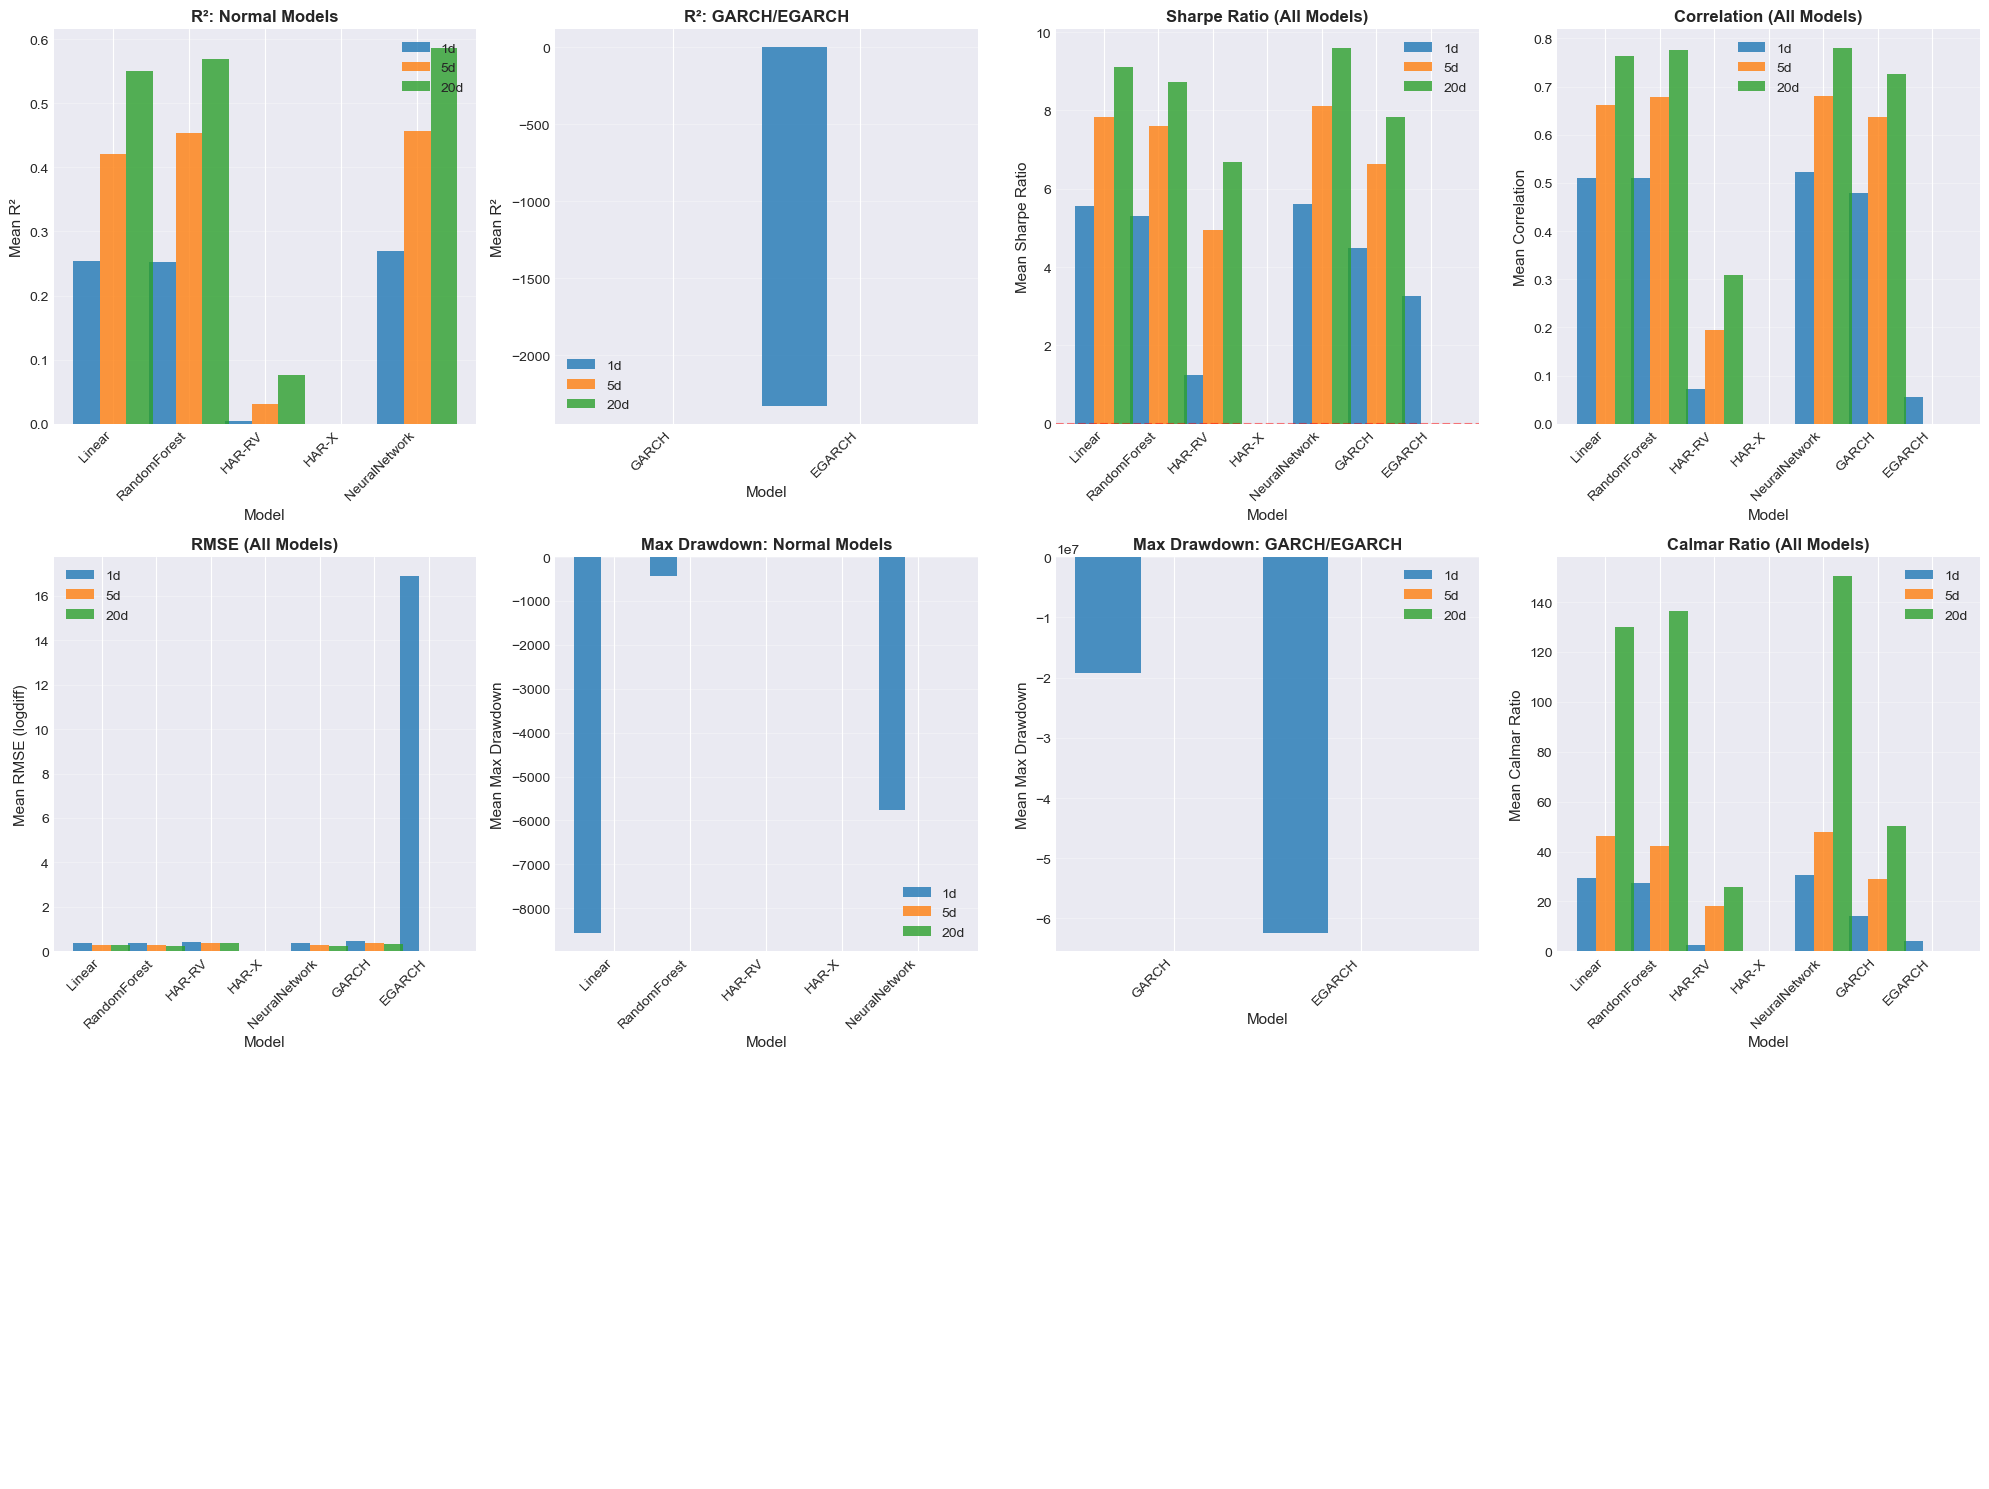

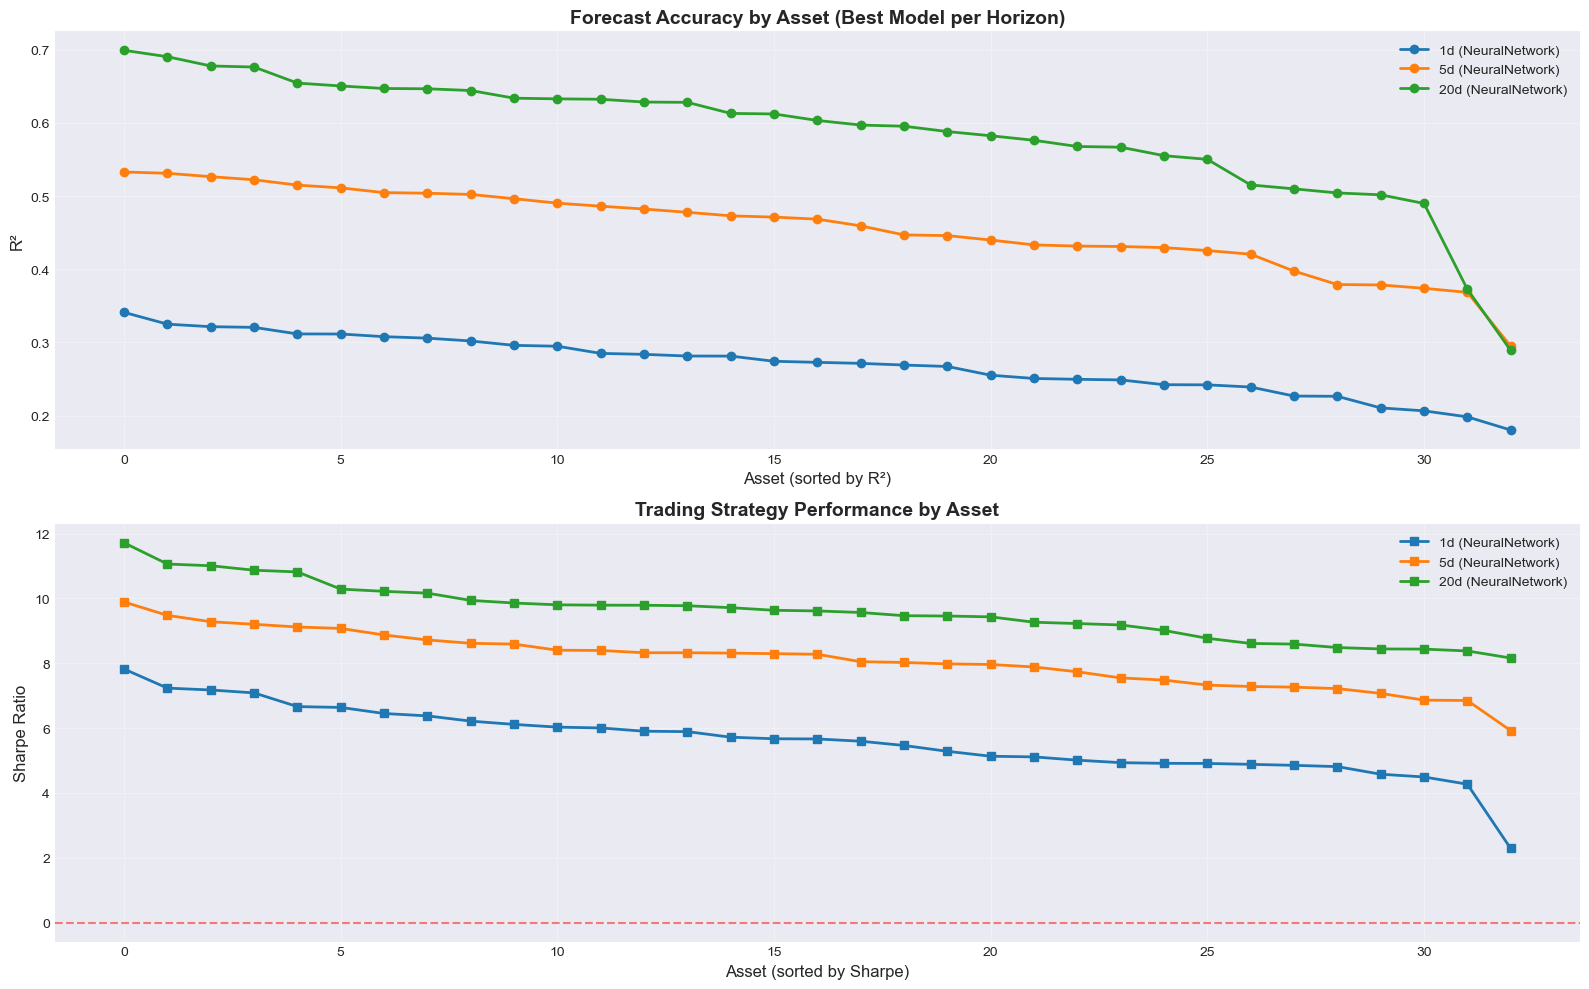

Visualizations saved.


In [12]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

if len(results_df) > 0:
    # Separate models into normal and GARCH/EGARCH groups
    normal_models = ['Linear', 'RandomForest', 'HAR-RV', 'HAR-X', 'NeuralNetwork']
    garch_models = ['GARCH', 'EGARCH']
    all_models_list = normal_models + garch_models
    
    # 1. Model Performance Comparison (3x4 grid)
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    # R²: Normal Models
    ax = axes[0, 0]
    x_pos = np.arange(len(normal_models))
    width = 0.35
    for i, horizon in enumerate(FORECAST_HORIZONS):
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_r2 = horizon_df[horizon_df['model'].isin(normal_models)].groupby('model')['r2'].mean()
        # Align with normal_models order
        values = [model_r2.get(model, 0) for model in normal_models]
        offset = width * (i - len(FORECAST_HORIZONS)/2 + 0.5)
        ax.bar(x_pos + offset, values, width, label=f'{horizon}d', alpha=0.8)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Mean R²', fontsize=11)
    ax.set_title('R²: Normal Models', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(normal_models, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # R²: GARCH/EGARCH
    ax = axes[0, 1]
    x_pos = np.arange(len(garch_models))
    width = 0.35
    for i, horizon in enumerate(FORECAST_HORIZONS):
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_r2 = horizon_df[horizon_df['model'].isin(garch_models)].groupby('model')['r2'].mean()
        values = [model_r2.get(model, 0) for model in garch_models]
        offset = width * (i - len(FORECAST_HORIZONS)/2 + 0.5)
        ax.bar(x_pos + offset, values, width, label=f'{horizon}d', alpha=0.8)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Mean R²', fontsize=11)
    ax.set_title('R²: GARCH/EGARCH', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(garch_models, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Sharpe Ratio (all models)
    ax = axes[0, 2]
    x_pos = np.arange(len(all_models_list))
    width = 0.35
    for i, horizon in enumerate(FORECAST_HORIZONS):
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_sharpe = horizon_df.groupby('model')['sharpe_ratio'].mean()
        values = [model_sharpe.get(model, 0) for model in all_models_list]
        offset = width * (i - len(FORECAST_HORIZONS)/2 + 0.5)
        ax.bar(x_pos + offset, values, width, label=f'{horizon}d', alpha=0.8)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Mean Sharpe Ratio', fontsize=11)
    ax.set_title('Sharpe Ratio (All Models)', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(all_models_list, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # Correlation (all models)
    ax = axes[0, 3]
    x_pos = np.arange(len(all_models_list))
    width = 0.35
    for i, horizon in enumerate(FORECAST_HORIZONS):
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_corr = horizon_df.groupby('model')['correlation'].mean()
        values = [model_corr.get(model, 0) for model in all_models_list]
        offset = width * (i - len(FORECAST_HORIZONS)/2 + 0.5)
        ax.bar(x_pos + offset, values, width, label=f'{horizon}d', alpha=0.8)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Mean Correlation', fontsize=11)
    ax.set_title('Correlation (All Models)', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(all_models_list, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # RMSE (all models)
    ax = axes[1, 0]
    x_pos = np.arange(len(all_models_list))
    width = 0.35
    for i, horizon in enumerate(FORECAST_HORIZONS):
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_rmse = horizon_df.groupby('model')['rmse_logdiff'].mean()
        values = [model_rmse.get(model, 0) for model in all_models_list]
        offset = width * (i - len(FORECAST_HORIZONS)/2 + 0.5)
        ax.bar(x_pos + offset, values, width, label=f'{horizon}d', alpha=0.8)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Mean RMSE (logdiff)', fontsize=11)
    ax.set_title('RMSE (All Models)', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(all_models_list, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Max Drawdown: Normal Models
    ax = axes[1, 1]
    x_pos = np.arange(len(normal_models))
    width = 0.35
    for i, horizon in enumerate(FORECAST_HORIZONS):
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_dd = horizon_df[horizon_df['model'].isin(normal_models)].groupby('model')['max_drawdown'].mean()
        values = [model_dd.get(model, 0) for model in normal_models]
        offset = width * (i - len(FORECAST_HORIZONS)/2 + 0.5)
        ax.bar(x_pos + offset, values, width, label=f'{horizon}d', alpha=0.8)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Mean Max Drawdown', fontsize=11)
    ax.set_title('Max Drawdown: Normal Models', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(normal_models, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Max Drawdown: GARCH/EGARCH
    ax = axes[1, 2]
    x_pos = np.arange(len(garch_models))
    width = 0.35
    for i, horizon in enumerate(FORECAST_HORIZONS):
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_dd = horizon_df[horizon_df['model'].isin(garch_models)].groupby('model')['max_drawdown'].mean()
        values = [model_dd.get(model, 0) for model in garch_models]
        offset = width * (i - len(FORECAST_HORIZONS)/2 + 0.5)
        ax.bar(x_pos + offset, values, width, label=f'{horizon}d', alpha=0.8)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Mean Max Drawdown', fontsize=11)
    ax.set_title('Max Drawdown: GARCH/EGARCH', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(garch_models, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Calmar Ratio (all models)
    ax = axes[1, 3]
    x_pos = np.arange(len(all_models_list))
    width = 0.35
    for i, horizon in enumerate(FORECAST_HORIZONS):
        horizon_df = results_df[results_df['horizon'] == horizon]
        model_calmar = horizon_df.groupby('model')['calmar_ratio'].mean()
        values = [model_calmar.get(model, 0) for model in all_models_list]
        offset = width * (i - len(FORECAST_HORIZONS)/2 + 0.5)
        ax.bar(x_pos + offset, values, width, label=f'{horizon}d', alpha=0.8)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Mean Calmar Ratio', fontsize=11)
    ax.set_title('Calmar Ratio (All Models)', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(all_models_list, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Hide unused subplots
    axes[2, 0].axis('off')
    axes[2, 1].axis('off')
    axes[2, 2].axis('off')
    axes[2, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig('cross_asset_model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 2. Performance by Asset
    if results_df['ticker'].nunique() > 1:
        fig, axes = plt.subplots(2, 1, figsize=(16, 10))
        
        # R² by asset (for best model per horizon)
        ax = axes[0]
        for horizon in FORECAST_HORIZONS:
            horizon_df = results_df[results_df['horizon'] == horizon]
            # Get best model for this horizon
            best_model = horizon_df.groupby('model')['r2'].mean().idxmax()
            asset_r2 = horizon_df[horizon_df['model'] == best_model].groupby('ticker')['r2'].mean().sort_values(ascending=False)
            ax.plot(range(len(asset_r2)), asset_r2.values, marker='o', label=f'{horizon}d ({best_model})', linewidth=2, markersize=6)
        ax.set_xlabel('Asset (sorted by R²)', fontsize=12)
        ax.set_ylabel('R²', fontsize=12)
        ax.set_title('Forecast Accuracy by Asset (Best Model per Horizon)', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Sharpe by asset
        ax = axes[1]
        for horizon in FORECAST_HORIZONS:
            horizon_df = results_df[results_df['horizon'] == horizon]
            best_model = horizon_df.groupby('model')['sharpe_ratio'].mean().idxmax()
            asset_sharpe = horizon_df[horizon_df['model'] == best_model].groupby('ticker')['sharpe_ratio'].mean().sort_values(ascending=False)
            ax.plot(range(len(asset_sharpe)), asset_sharpe.values, marker='s', label=f'{horizon}d ({best_model})', linewidth=2, markersize=6)
        ax.set_xlabel('Asset (sorted by Sharpe)', fontsize=12)
        ax.set_ylabel('Sharpe Ratio', fontsize=12)
        ax.set_title('Trading Strategy Performance by Asset', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.savefig('cross_asset_performance_by_asset.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    print("Visualizations saved.")
else:
    print("No results to visualize yet.")


In [13]:
# ============================================================================
# HONEST ASSESSMENT: WHAT WORKS AND WHAT DOESN'T
# ============================================================================

print("=" * 70)
print("HONEST ASSESSMENT: WHAT WORKS AND WHAT DOESN'T")
print("=" * 70)

if len(results_df) > 0:
    # Overall statistics
    print("\n1. FORECAST ACCURACY (R²):")
    print("-" * 70)
    overall_r2 = results_df.groupby('model')['r2'].agg(['mean', 'std', 'count'])
    overall_r2 = overall_r2.sort_values('mean', ascending=False)
    print(overall_r2.round(4))
    
    print("\n2. TRADING STRATEGY PERFORMANCE (Sharpe Ratio):")
    print("-" * 70)
    overall_sharpe = results_df.groupby('model')['sharpe_ratio'].agg(['mean', 'std', 'count'])
    overall_sharpe = overall_sharpe.sort_values('mean', ascending=False)
    print(overall_sharpe.round(4))
    
    print("\n3. KEY FINDINGS:")
    print("-" * 70)
    
    # Best forecasters
    best_forecasters = overall_r2.head(3)
    print(f"\nBest Forecasters (by R²):")
    for model, row in best_forecasters.iterrows():
        print(f"  {model}: R² = {row['mean']:.4f} ± {row['std']:.4f} (n={int(row['count'])})")
    
    # Best traders
    best_traders = overall_sharpe[overall_sharpe['mean'] > 0].head(3)
    if len(best_traders) > 0:
        print(f"\nBest Trading Strategies (by Sharpe, positive only):")
        for model, row in best_traders.iterrows():
            print(f"  {model}: Sharpe = {row['mean']:.4f} ± {row['std']:.4f} (n={int(row['count'])})")
    else:
        print(f"\n⚠️  WARNING: No models achieved positive Sharpe ratios on average!")
        print("   This suggests the trading strategies may not be profitable after transaction costs.")
    
    # Horizon analysis
    print(f"\n4. PERFORMANCE BY HORIZON:")
    print("-" * 70)
    for horizon in FORECAST_HORIZONS:
        horizon_df = results_df[results_df['horizon'] == horizon]
        print(f"\n{horizon}d Horizon:")
        print(f"  Best R²: {horizon_df.groupby('model')['r2'].mean().idxmax()} ({horizon_df.groupby('model')['r2'].mean().max():.4f})")
        print(f"  Best Sharpe: {horizon_df.groupby('model')['sharpe_ratio'].mean().idxmax()} ({horizon_df.groupby('model')['sharpe_ratio'].mean().max():.4f})")
        print(f"  Mean R² across all models: {horizon_df['r2'].mean():.4f}")
        print(f"  Mean Sharpe across all models: {horizon_df['sharpe_ratio'].mean():.4f}")
    
    # What doesn't work
    print(f"\n5. WHAT DOESN'T WORK:")
    print("-" * 70)
    negative_sharpe = overall_sharpe[overall_sharpe['mean'] < 0]
    if len(negative_sharpe) > 0:
        print("Models with negative average Sharpe ratios (unprofitable strategies):")
        for model, row in negative_sharpe.iterrows():
            print(f"  {model}: Sharpe = {row['mean']:.4f}")
    
    low_r2 = overall_r2[overall_r2['mean'] < 0.1]
    if len(low_r2) > 0:
        print("\nModels with very low R² (< 0.1, poor forecast accuracy):")
        for model, row in low_r2.iterrows():
            print(f"  {model}: R² = {row['mean']:.4f}")
    
    # Robustness check
    print(f"\n6. ROBUSTNESS CHECK:")
    print("-" * 70)
    print("Standard deviations indicate consistency across assets:")
    print(f"  Most consistent forecaster (lowest R² std): {overall_r2['std'].idxmin()} (std={overall_r2['std'].min():.4f})")
    print(f"  Most consistent trader (lowest Sharpe std): {overall_sharpe['std'].idxmin()} (std={overall_sharpe['std'].min():.4f})")
    
    print(f"\n7. CONCLUSIONS:")
    print("-" * 70)
    print("Based on the analysis above:")
    print("  • Forecast accuracy (R²) measures prediction quality")
    print("  • Sharpe ratio measures trading strategy profitability")
    print("  • High R² does not guarantee profitable trading (transaction costs matter)")
    print("  • Different horizons may favor different models")
    print("  • Cross-asset robustness is important for generalization")
    
else:
    print("No results to analyze yet.")


HONEST ASSESSMENT: WHAT WORKS AND WHAT DOESN'T

1. FORECAST ACCURACY (R²):
----------------------------------------------------------------------
                    mean        std  count
model                                     
NeuralNetwork     0.4372     0.1449     99
RandomForest      0.4250     0.1668     99
Linear            0.4084     0.1524     99
GARCH             0.0806     0.2594     99
HAR-RV            0.0375     0.0418     99
EGARCH        -2327.6414  2195.3543     33

2. TRADING STRATEGY PERFORMANCE (Sharpe Ratio):
----------------------------------------------------------------------
                 mean     std  count
model                               
NeuralNetwork  7.7693  1.8940     99
Linear         7.5024  1.6853     99
RandomForest   7.2146  1.6717     99
GARCH          6.3169  1.6342     99
HAR-RV         4.2923  2.3771     99
EGARCH         3.2739  0.9573     33

3. KEY FINDINGS:
----------------------------------------------------------------------

Best